In [1]:
from IPython.lib.deepreload import original_import
%load_ext autoreload
%autoreload 2

import ex4
import numpy as np
import matplotlib.pyplot as plt

In [19]:
# garden_video="Garden.mp4"
house_video="House.mp4"
frames = ex4.load_video_frames(house_video, downscale_factor=2)
panorama = ex4.create_mosaic(frames, step_size=16, border_cut=15)
print("done.")

Loading video from: Exercise Inputs/House.mp4
Successfully loaded 435 frames. Shape: (435, 360, 640)
Calculating canvas limits...
Creating panorama with rotation_correction=False.
Frame 1: Correction (dy=0.00, dth=0.00°)
Frame 2: Correction (dy=0.00, dth=0.00°)
Frame 3: Correction (dy=-0.14, dth=0.00°)
Frame 4: Correction (dy=-0.14, dth=0.00°)
Frame 5: Correction (dy=-0.14, dth=0.00°)
Frame 6: Correction (dy=-1.41, dth=0.00°)
Frame 7: Correction (dy=-1.41, dth=0.00°)
Frame 8: Correction (dy=-1.41, dth=0.00°)
Frame 9: Correction (dy=-1.38, dth=0.00°)
Frame 10: Correction (dy=-1.38, dth=0.00°)
Frame 11: Correction (dy=-1.38, dth=0.00°)
Frame 12: Correction (dy=-2.09, dth=0.00°)
Frame 13: Correction (dy=-2.09, dth=0.00°)
Frame 14: Correction (dy=-2.09, dth=0.00°)
Frame 15: Correction (dy=-2.96, dth=0.00°)
Frame 16: Correction (dy=-2.96, dth=0.00°)
Frame 17: Correction (dy=-2.96, dth=0.00°)
Frame 18: Correction (dy=-1.83, dth=0.00°)
Frame 19: Correction (dy=-1.83, dth=0.00°)
Frame 20: Corr

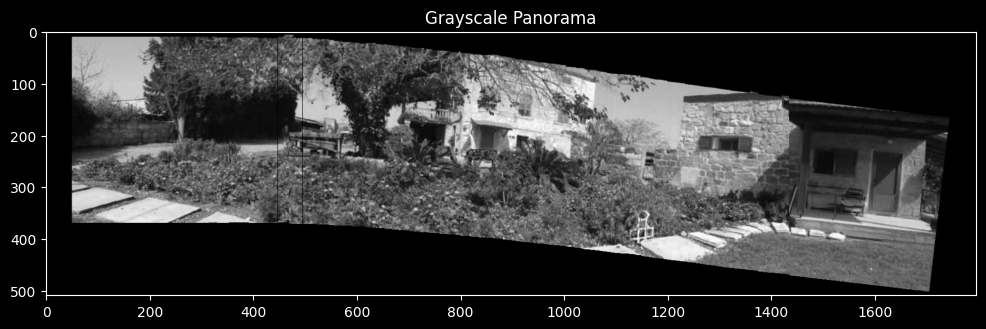

In [20]:
plt.figure(figsize=(12, 6))
plt.imshow(panorama, cmap='gray')
plt.title("Grayscale Panorama")
plt.show()

In [21]:
ex4.save_panorama(panorama, filename="house_panorama_gray_wo_rot.png")

Saving panorama to: outputs/house_panorama_gray_wo_rot.png...
Success! Image saved.


Analyzing camera path...


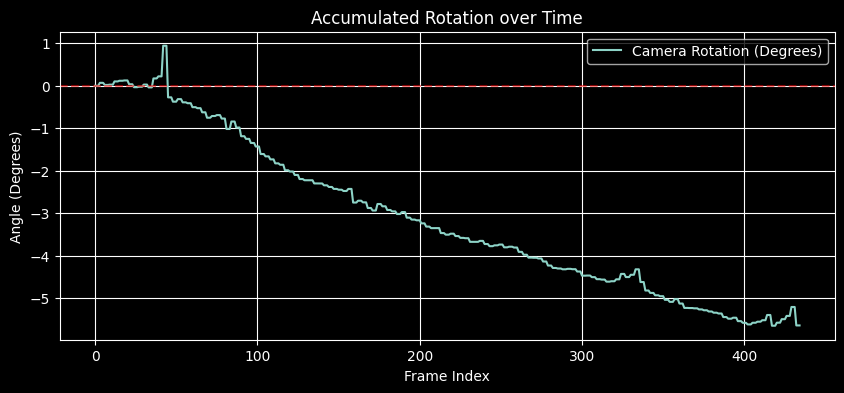

Total Rotation: -5.64 degrees


[0,
 np.float64(3.6793235516486134e-06),
 np.float64(9.653912915021086e-06),
 np.float64(0.06974586167676153),
 np.float64(0.0697475613501533),
 np.float64(0.06974755370965839),
 np.float64(0.020166850113284063),
 np.float64(0.020156085199587868),
 np.float64(0.020149616251893984),
 np.float64(0.02702018046126902),
 np.float64(0.027094512953555003),
 np.float64(0.027105853582122724),
 np.float64(0.1028458115752215),
 np.float64(0.1028353981108015),
 np.float64(0.10277788639639886),
 np.float64(0.1186846860296647),
 np.float64(0.11867683105740341),
 np.float64(0.11865693806929901),
 np.float64(0.1261708569176059),
 np.float64(0.12618367491559435),
 np.float64(0.12617846561290666),
 np.float64(0.0360389276417002),
 np.float64(0.036018131997897426),
 np.float64(0.03605459147946064),
 np.float64(-0.03327410411632797),
 np.float64(-0.033255226089214926),
 np.float64(-0.03324821738076233),
 np.float64(-0.022819646766078307),
 np.float64(-0.022831098644145644),
 np.float64(-0.0228313717672292

In [22]:
def plot_camera_path(frames, step_size, border_cut):
    thetas = [0]
    cumulative_theta = 0

    print("Analyzing camera path...")
    for i in range(len(frames) - 1):
        _, _, theta = ex4.optical_flow(frames[i], frames[i+1], step_size, border_cut)
        cumulative_theta += theta
        thetas.append(np.rad2deg(cumulative_theta))

    plt.figure(figsize=(10, 4))
    plt.plot(thetas, label='Camera Rotation (Degrees)')
    plt.axhline(y=0, color='r', linestyle='--', alpha=0.5)
    plt.title("Accumulated Rotation over Time")
    plt.xlabel("Frame Index")
    plt.ylabel("Angle (Degrees)")
    plt.legend()
    plt.grid(True)
    plt.show()

    print(f"Total Rotation: {thetas[-1]:.2f} degrees")
    return thetas

plot_camera_path(frames, step_size=16, border_cut=15)